# Data Processing

In [1]:
import pandas as pd
import numpy as np
import datetime
import random
import matplotlib.pyplot as plt

import gym
from gym_anytrading.envs import StocksEnv
from finta import TA

from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C
from stable_baselines3 import PPO

In [2]:
df = pd.read_csv("apple.csv")

In [3]:
df.head()

,Date,Open,High,Low,Close,Volume
0,2/25/2022,163.84,165.12,160.87,164.85,"91,974,227"
1,2/24/2022,152.58,162.85,152.00,162.74,"141,147,500"
2,2/23/2022,165.54,166.15,159.75,160.07,"90,009,250"
3,2/22/2022,164.98,166.69,162.15,164.32,"91,162,758"
4,2/18/2022,169.82,170.54,166.19,167.30,"82,772,672"


In [4]:
df.dtypes

Date       object
Open      float64
High      float64
Low       float64
Close     float64
Volume     object
dtype: object

In [5]:
df["Date"] = pd.to_datetime(df["Date"])
df.sort_values("Date", ascending=True, inplace=True)
df.set_index("Date", inplace=True)
df["Volume"] = df["Volume"].apply(lambda x: float(x.replace(",", "")))
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2019-02-25,43.54,43.97,43.49,43.56,87493436.0
2019-02-26,43.43,43.83,43.29,43.58,68280844.0
2019-02-27,43.30,43.75,43.18,43.72,111341564.0
2019-02-28,43.58,43.73,43.23,43.29,112861680.0
2019-03-01,43.57,43.79,43.22,43.74,103544680.0


In [6]:
df["SMA"] = TA.SMA(df, 12)
df["RSI"] = TA.RSI(df)
df["OBV"] = TA.OBV(df)
df.fillna(0, inplace=True)
df.head()

,Open,High,Low,Close,Volume,SMA,RSI,OBV
Date,,,,,,,,
2019-02-25,43.54,43.97,43.49,43.56,87493436.0,0.0,0.00000,0.0
2019-02-26,43.43,43.83,43.29,43.58,68280844.0,0.0,100.00000,68280844.0
2019-02-27,43.30,43.75,43.18,43.72,111341564.0,0.0,100.00000,179622408.0
2019-02-28,43.58,43.73,43.23,43.29,112861680.0,0.0,25.50822,66760728.0
2019-03-01,43.57,43.79,43.22,43.74,103544680.0,0.0,59.50503,170305408.0


In [7]:
window_frame = 20

train_frame = (window_frame,int(len(df)*0.7))
test_frame = (int(len(df)*0.7),int(len(df)))
train_steps = 10000

# Random Actions

info {'total_reward': 49.85000000000008, 'total_profit': 0.31619764947368156, 'position': 1}


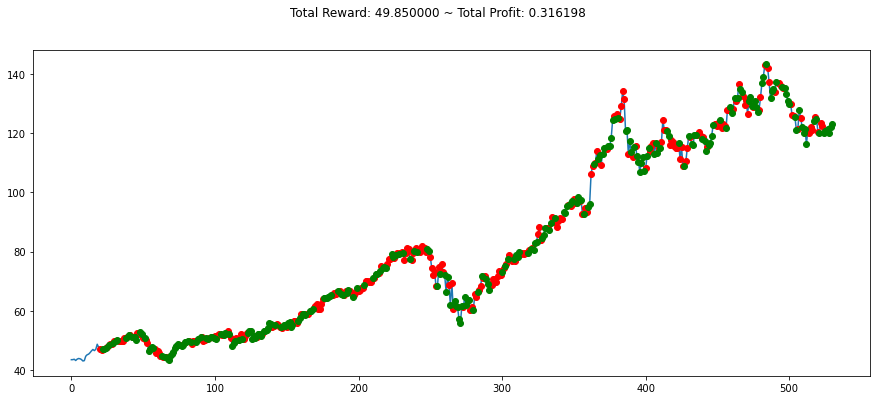

In [8]:
# Train Set Evaluation
env = gym.make('stocks-v0', df=df, frame_bound=train_frame, window_size=window_frame)
states = env.observation_space.shape
actions = env.action_space.n

state = env.reset()
while True: 
    action = env.action_space.sample()
    n_state, reward, done, info = env.step(action)
    if done: 
        print("info", info)
        break
        
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

info {'total_reward': 8.88000000000011, 'total_profit': 0.4665919136531912, 'position': 0}


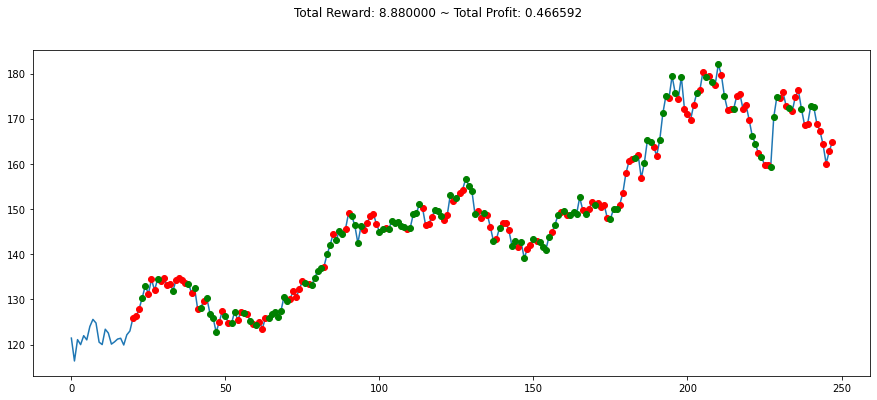

In [9]:
# Test Set Evaluation
env = gym.make('stocks-v0', df=df, frame_bound=test_frame, window_size=window_frame)
states = env.observation_space.shape
actions = env.action_space.n

state = env.reset()
while True: 
    action = env.action_space.sample()
    n_state, reward, done, info = env.step(action)
    if done: 
        print("info", info)
        break
        
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

# Default Environment

In [10]:
env_maker = lambda: gym.make('stocks-v0', df=df, frame_bound=train_frame, window_size=window_frame)
env = DummyVecEnv([env_maker])

In [11]:
model = A2C("MlpPolicy", env, verbose=0)
model.learn(total_timesteps=train_steps)

info {'total_reward': 44.42999999999998, 'total_profit': 0.29868354241626005, 'position': 0}


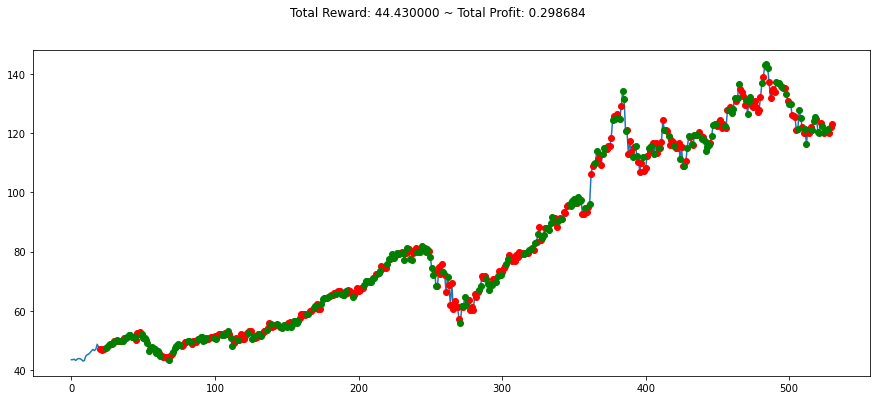

In [12]:
# Train Set Evaluation
env = gym.make('stocks-v0', df=df, frame_bound=train_frame, window_size=window_frame)
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break
        
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

info {'total_reward': 12.170000000000186, 'total_profit': 0.45262200703290867, 'position': 0}


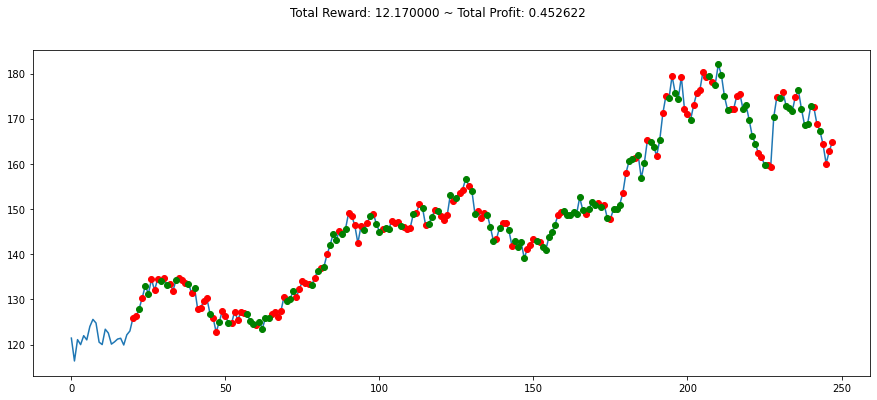

In [13]:
# Test Set Evaluation
env = gym.make('stocks-v0', df=df, frame_bound=test_frame, window_size=window_frame)
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break
        
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

# Building the Custom Environment

In [14]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, "Low"].to_numpy()[start:end]
    signal_features = env.df.loc[:, ["Open", "High", "Low", "Close", "Volume", "SMA", "RSI", "OBV"]].to_numpy()[start:end] # Can add more features
#     signal_features = env.df.loc[:, ["Low", "Volume", "SMA", "RSI", "OBV"]].to_numpy()[start:end] # Can add more features
    return prices, signal_features

In [15]:
class MyCustomEnv(StocksEnv):
    _process_data = add_signals

In [16]:
env_maker = lambda: MyCustomEnv(df=df, frame_bound=train_frame, window_size=window_frame)
env = DummyVecEnv([env_maker])

In [17]:
model = A2C("MlpPolicy", env, verbose=0)
model.learn(total_timesteps=train_steps)

info {'total_reward': 59.329999999999956, 'total_profit': 0.29295181619312494, 'position': 1}


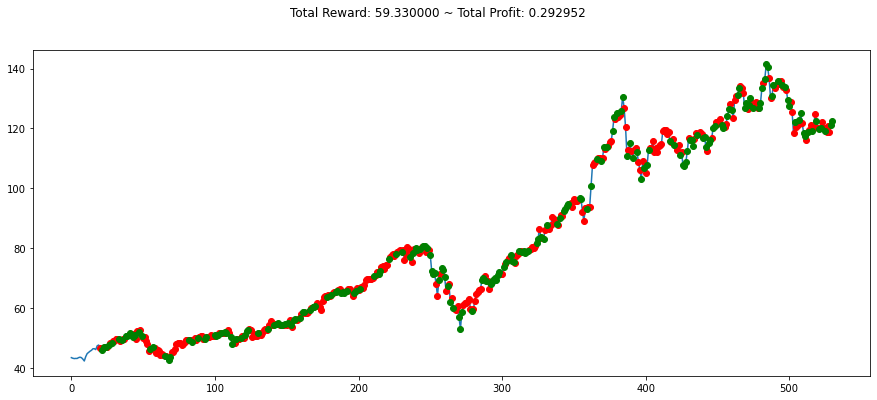

In [18]:
# Train Set Evaluation
env = MyCustomEnv(df=df, frame_bound=train_frame, window_size=window_frame)
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break
        
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

info {'total_reward': 1.8299999999999983, 'total_profit': 0.4481952744845515, 'position': 1}


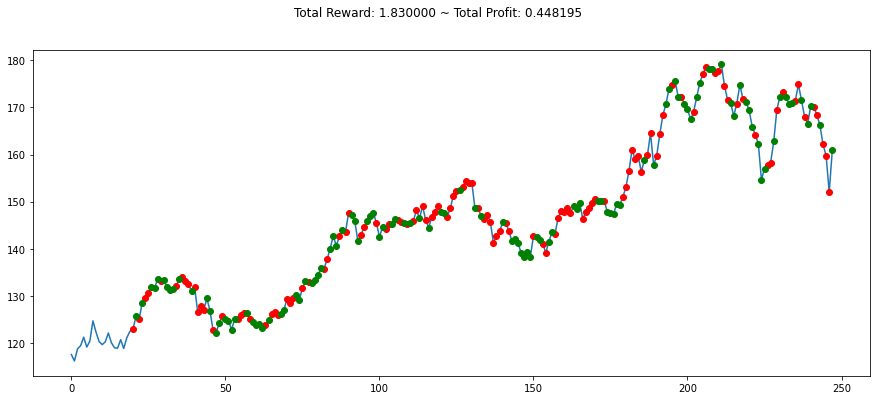

In [19]:
# Test Set Evaluation
env = MyCustomEnv(df=df, frame_bound=test_frame, window_size=window_frame)
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break
        
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

# Summary
